In [82]:
import pandas as pd
import time
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt

In [83]:
df_avax = pd.read_csv("../data/AVAXUSDT_15m.csv")
df_bnb = pd.read_csv("../data/BNBUSDT_15m.csv")
df_btc = pd.read_csv("../data/BTCUSDT_15m.csv")
df_eth = pd.read_csv("../data/ETHUSDT_15m.csv")
dict_df={
    "avax":df_avax,
    "bnb": df_bnb,
    "btc":df_btc,
    "eth": df_eth
}

In [84]:
df_btc.head()

,openTime,open,high,low,close,volume,closeTime,quoteAssetVolume,numberOfTrades,takerBuyBase,takerBuyQuote,ignore
0,2020-09-17 12:45:00+00:00,10846.15,10847.06,10800.01,10803.95,597.639102,2020-09-17 12:59:59.999000+00:00,6.467132e+06,8632,244.025994,2.640912e+06,0
1,2020-09-17 13:00:00+00:00,10803.95,10820.65,10745.83,10769.31,1581.175014,2020-09-17 13:14:59.999000+00:00,1.704408e+07,14769,664.005481,7.157146e+06,0
2,2020-09-17 13:15:00+00:00,10769.31,10799.00,10756.77,10781.00,748.213413,2020-09-17 13:29:59.999000+00:00,8.064910e+06,11097,351.875530,3.792940e+06,0
3,2020-09-17 13:30:00+00:00,10781.11,10794.50,10762.68,10778.08,684.306532,2020-09-17 13:44:59.999000+00:00,7.376073e+06,9383,318.177799,3.429786e+06,0
4,2020-09-17 13:45:00+00:00,10778.09,10822.00,10776.10,10819.91,787.662968,2020-09-17 13:59:59.999000+00:00,8.511489e+06,8946,433.376133,4.682812e+06,0


# New features

In [85]:
list_crypto = ["avax","bnb","btc","eth"]

In [ ]:
def cleaner(df):
    df = df.drop(columns=["ignore"])
    df["log_return"] = np.log(df["close"]/df["open"])
    df["volume"] = df["volume"].replace(0, np.nan)  # Remplace 0 par NaN
    df["log_vol"] = np.log(df["volume"])
    df["openTime"] = df["openTime"]
    return df

In [87]:
clean_btc = cleaner(df_btc)

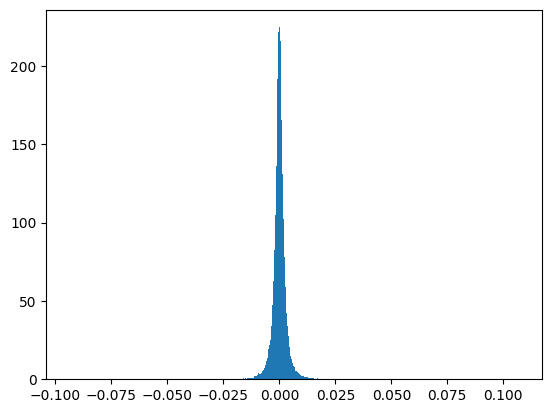

In [88]:
plt.figure()
plt.hist(clean_btc["log_return"],bins=1000, density=True)
plt.show()

## High-low-day detector

In [109]:
def current_max_low(df):
    # S'assurer que la colonne date est bien en datetime
    df["date"] = pd.to_datetime(df["closeTime"], utc=True, errors="coerce")
    df["day"] = df["date"].dt.date
    # Rolling max et min du close pour chaque jour
    df["cummax_close"] = df.groupby("day")["close"].cummax()
    df["cummin_close"] = df.groupby("day")["close"].cummin()
    # True si le close actuel est le max ou min du jour jusqu'à présent
    df["is_current_max"] = df["close"] == df["cummax_close"]
    df["is_current_min"] = df["close"] == df["cummin_close"]
    return df

In [110]:
def detect_high_of_day(df):
    # S'assurer que la colonne date est bien en datetime
    df["date"] = pd.to_datetime(df["closeTime"], utc=True, errors="coerce")
    # Extraire la date (sans l'heure)
    df["day"] = df["date"].dt.date
    # Trouver le prix max de chaque journée
    daily_high = df.groupby("day")["close"].transform("max")
    daily_min = df.groupby("day")["close"].transform("min")
    # Créer une colonne booléenne : True si c'est le plus haut de la journée
    df["is_high_of_day"] = df["close"] == daily_high
    df["is_min_of_day"] = df["close"] == daily_min
    return df


In [111]:
clean_btc = detect_high_of_day(df_btc)
clean_btc = current_max_low(clean_btc)

In [112]:
clean_btc.head()

,openTime,open,high,low,close,volume,closeTime,quoteAssetVolume,numberOfTrades,takerBuyBase,takerBuyQuote,ignore,date,day,is_high_of_day,is_min_of_day,cummax_close,is_current_max,cummin_close,is_current_min
0,2020-09-17 12:45:00+00:00,10846.15,10847.06,10800.01,10803.95,597.639102,2020-09-17 12:59:59.999000+00:00,6.467132e+06,8632,244.025994,2.640912e+06,0,2020-09-17 12:59:59.999000+00:00,2020-09-17,False,False,10803.95,True,10803.95,True
1,2020-09-17 13:00:00+00:00,10803.95,10820.65,10745.83,10769.31,1581.175014,2020-09-17 13:14:59.999000+00:00,1.704408e+07,14769,664.005481,7.157146e+06,0,2020-09-17 13:14:59.999000+00:00,2020-09-17,False,True,10803.95,False,10769.31,True
2,2020-09-17 13:15:00+00:00,10769.31,10799.00,10756.77,10781.00,748.213413,2020-09-17 13:29:59.999000+00:00,8.064910e+06,11097,351.875530,3.792940e+06,0,2020-09-17 13:29:59.999000+00:00,2020-09-17,False,False,10803.95,False,10769.31,False
3,2020-09-17 13:30:00+00:00,10781.11,10794.50,10762.68,10778.08,684.306532,2020-09-17 13:44:59.999000+00:00,7.376073e+06,9383,318.177799,3.429786e+06,0,2020-09-17 13:44:59.999000+00:00,2020-09-17,False,False,10803.95,False,10769.31,False
4,2020-09-17 13:45:00+00:00,10778.09,10822.00,10776.10,10819.91,787.662968,2020-09-17 13:59:59.999000+00:00,8.511489e+06,8946,433.376133,4.682812e+06,0,2020-09-17 13:59:59.999000+00:00,2020-09-17,False,False,10819.91,True,10769.31,False


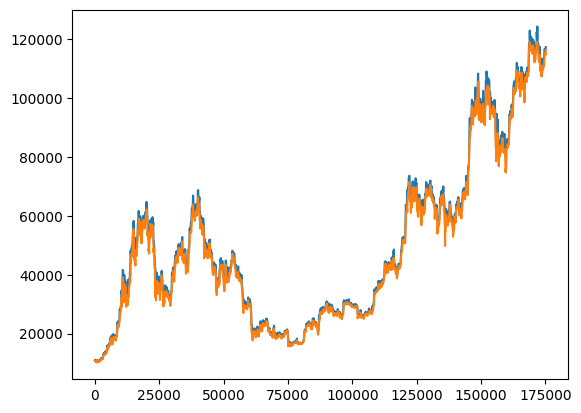

In [113]:
plt.figure()
plt.plot(clean_btc[clean_btc["is_high_of_day"]==True]["close"])
plt.plot(clean_btc[clean_btc["is_min_of_day"]==True]["close"])
plt.show()

In [117]:
clean_btc.columns

Index(['openTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime',
       'quoteAssetVolume', 'numberOfTrades', 'takerBuyBase', 'takerBuyQuote',
       'ignore', 'date', 'day', 'is_high_of_day', 'is_min_of_day',
       'cummax_close', 'is_current_max', 'cummin_close', 'is_current_min'],
      dtype='object')

## Moving average

In [115]:
def mva(df,window):
    df[f'mva_{window}'] = df['close'].rolling(window=window).mean()
    return df

In [118]:
def preparation_data(df,name):
    data = cleaner(df)
    data = mva(data,20)
    data = mva(data,50)
    data = mva(data,100)
    data = current_max_low(data)
    data = detect_high_of_day(data)
    data = data.columns(['openTime', 'open', 'high', 'low', 'close', 'volume', 'closeTime',
       'quoteAssetVolume', 'numberOfTrades', 'takerBuyBase', 'takerBuyQuote', 
       'date', 'day', 'is_current_max', 'cummin_close', 'is_high_of_day', 'is_min_of_day'])
    data.to_csv(f"../data/cleaned_data_{name}.csv", index=False)
    return data